In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import head_direction.head as head
import spatial_maps as sp
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
from distutils.dir_util import copy_tree
from neo import SpikeTrain
import scipy

from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

from spike_statistics.core import permutation_resampling

from spikewaveform.core import calculate_waveform_features_from_template, cluster_waveform_features

from septum_mec.analysis.plotting import violinplot

11:07:18 [I] klustakwik KlustaKwik2 version 0.2.6


In [3]:
%matplotlib inline
color_control = '#4393c3'
color_stimulated = '#d6604d'

color_bs = '#5aae61'
color_ns = '#9970ab'

figsize_violin = (1.7, 3)
figsize_gen = (4, 3)

output_path = pathlib.Path("output") / "some-analysis"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)
output_path.mkdir(exist_ok=True)

In [4]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [7]:
identify_neurons = actions['identify-neurons']
sessions = pd.read_csv(identify_neurons.data_path('sessions'))
units = pd.read_csv(identify_neurons.data_path('units'))
session_units = pd.merge(sessions, units, on='action')

In [8]:
waveform_action = actions['waveform-analysis']
waveform_results = pd.read_csv(waveform_action.data_path('results'))

In [9]:
stimulus_action = actions['stimulus-response']
stimulus_results = pd.read_csv(stimulus_action.data_path('results'))

In [14]:
len(stimulus_results)

1298

In [10]:
all_results = session_units.merge(
    waveform_results.merge(stimulus_results), how='left')

In [15]:
len(all_results)

1298

Text(0.5, 0.98, 'NS')

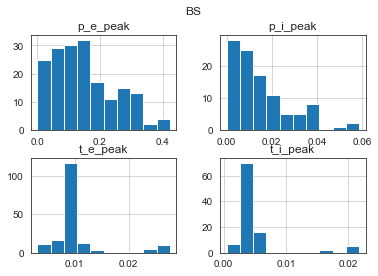

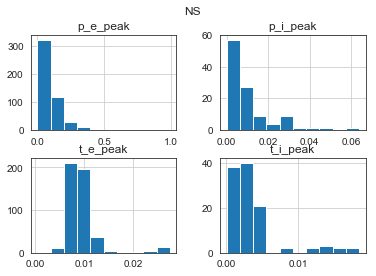

In [11]:
all_results.query('bs==0').loc[:,['t_i_peak', 't_e_peak', 'p_i_peak', 'p_e_peak']].hist()
plt.gcf().suptitle('BS')
all_results.query('bs==1').loc[:,['t_i_peak', 't_e_peak', 'p_i_peak', 'p_e_peak']].hist()
plt.gcf().suptitle('NS')

In [61]:
lfp_action = actions['stimulus-lfp-response']
lfp_results = pd.read_csv(lfp_action.data_path('results'))

In [62]:
lfp_results.keys()

Index(['action', 'baseline', 'channel_group', 'entity', 'frequency', 'i', 'ii',
       'session', 'stim_location', 'stimulated', 'tag', 'theta_freq',
       'theta_peak', 'theta_energy', 'theta_half_f1', 'theta_half_f2',
       'theta_half_width', 'theta_half_energy', 'stim_freq', 'stim_p_max',
       'stim_half_f1', 'stim_half_f2', 'stim_half_width', 'stim_energy'],
      dtype='object')

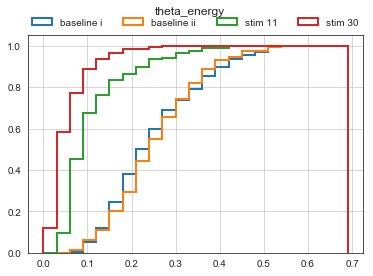

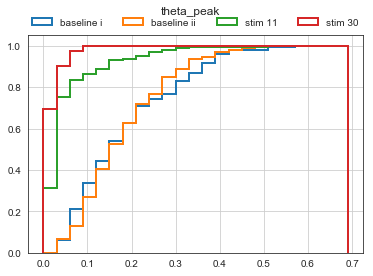

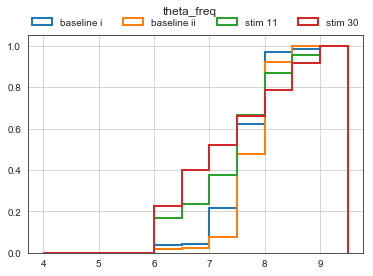

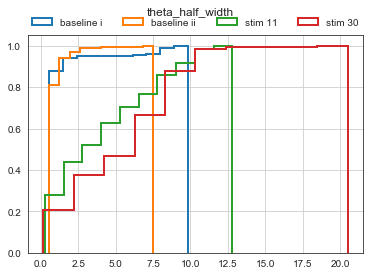

In [63]:

density = True
cumulative = True
histtype = 'step'
lw = 2
bins = {
    'theta_energy': np.arange(0, .7, .03),
    'theta_peak': np.arange(0, .7, .03),
    'theta_freq': np.arange(4, 10, .5),
    'theta_half_width':None
}
# key = 'theta_energy'
# key = 'theta_peak'
for key in bins:
    plt.figure()
    plt.suptitle(key)
    lfp_results.query('baseline and i')[key].hist(
        bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
        histtype=histtype, label='baseline i')

    lfp_results.query('baseline and ii')[key].hist(
        bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
        histtype=histtype, label='baseline ii')

    lfp_results.query('frequency==11')[key].hist(
        bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
        histtype=histtype, label='stim 11')

    lfp_results.query('frequency==30')[key].hist(
        bins=bins[key], density=density, cumulative=cumulative, lw=lw,
        histtype=histtype, label='stim 30')
    plt.legend(
        bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
        mode="expand", borderaxespad=0, ncol=4, frameon=False)

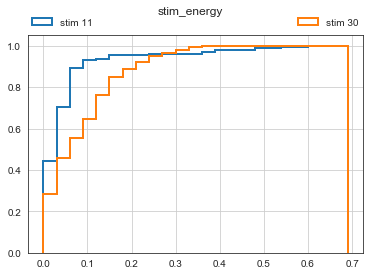

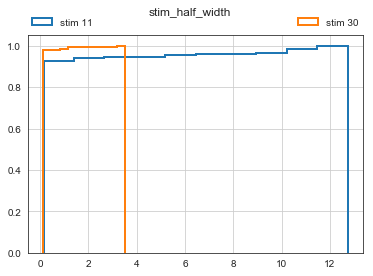

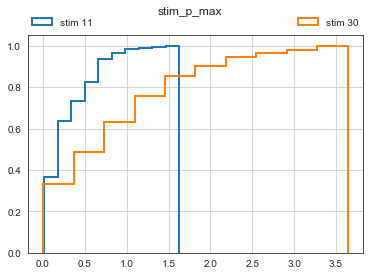

In [64]:

density = True
cumulative = True
histtype = 'step'
lw = 2
bins = {
    'stim_energy': np.arange(0, .7, .03),
    'stim_half_width': None,
    'stim_p_max':None
}
# key = 'theta_energy'
# key = 'theta_peak'
for key in bins:
    plt.figure()
    plt.suptitle(key)
 
    lfp_results.query('frequency==11')[key].hist(
        bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
        histtype=histtype, label='stim 11')

    lfp_results.query('frequency==30')[key].hist(
        bins=bins[key], density=density, cumulative=cumulative, lw=lw,
        histtype=histtype, label='stim 30')
    plt.legend(
        bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
        mode="expand", borderaxespad=0, ncol=4, frameon=False)

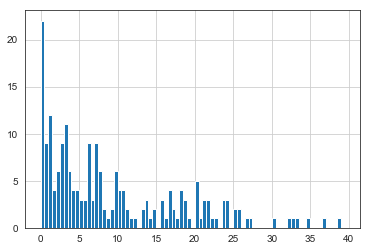

In [65]:
d = lfp_results.query('frequency==11')
(d['stim_p_max'] / d['theta_peak']).hist(bins=np.arange(0, 40, .5))

In [68]:
d[(d['stim_p_max'] / d['theta_peak']) < 1].iloc[0].T

action               1833-260619-2
baseline                     False
channel_group                    2
entity                        1833
frequency                       11
i                             True
ii                           False
session                          2
stim_location                   ms
stimulated                    True
tag                         stim i
theta_freq                     9.6
theta_peak                0.221494
theta_energy              0.428502
theta_half_f1              9.31331
theta_half_f2              10.2056
theta_half_width          0.892312
theta_half_energy         0.163807
stim_freq                  11.1107
stim_p_max               0.0997192
stim_half_f1               10.9279
stim_half_f2               11.7259
stim_half_width           0.798003
stim_energy              0.0715158
Name: 154, dtype: object

# Store results in Expipe action

In [144]:
action = project.require_action("some-analysis")

In [145]:
stuff = {
    "figures": "figures",
    "statistics": "statistics"
}

for key, value in stuff.items():
    action.data[key] = value
    data_path = action.data_path(key)
    data_path.parent.mkdir(exist_ok=True, parents=True)
    source = output_path / value
    if source.is_file():
        shutil.copy(source, data_path)
    else:
        copy_tree(str(source), str(data_path))

In [146]:
septum_mec.analysis.registration.store_notebook(action, "20_some_analysis.ipynb")